<a href="https://colab.research.google.com/github/mariabessa/IA-labirinto/blob/main/Busca-em-espaco-estados/Trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc

# Classe Labirinto


In [1]:
class Labirinto:

  def __init__(self,dim=10):

    # Inicializando o labirinto. Nele, vamos considerar que todas as celulas sao paredes
    self.labirintoPlot    =  np.zeros((dim,dim,3), dtype=np.int64)
    self.labirintoArestas =  np.zeros((dim,dim), dtype=np.int64)
    self.dim = dim

    # Selecionar uma celula parede do labirinto como ponto inicial. Com a selecao abaixo,
    # o labirinto sempre tera seu inicio no canto esquerdo do grafico
    posicaoInicial = np.random.randint(0, (dim-1))


    fronteira = []
    fronteira.append((posicaoInicial,0))
    dx = [ 0, 1, 0, -1] # Movimentacao de x
    dy = [-1, 0, 1,  0] # movimentacao de y

    while fronteira != []:
      # Transformar a celula (parede) do labirinto em uma celula valida
      (vx, vy) = fronteira[-1] # Selecionando o ultimo elemento da lista
      self.labirintoArestas[vx,vy] = 1

      # verificar se a celula (parede) possui somente um vizinho que nao seja parede
      # caso sim, podemos incluir ela como uma passagem.
      vizinhosNaoVisitados=[]

      # Consideramos que a celula tem vizinhos acima, abaixo a esquerda e a direita.
      # Para isso, utilizamos as listas dx e dy para determinar essas posicoes
      for i in range(4):
        nx = vx + dx[i]
        ny = vy + dy[i]

        if nx >=0 and nx < dim and ny >=0 and ny < dim:
          if self.labirintoArestas[nx, ny] == 0:

            confereVizinho=0
            for j in range(4):
              ex = nx + dx[j]
              ey = ny + dy[j]

              if ex >=0 and ex < dim and ey >=0 and ey < dim:
                if self.labirintoArestas[ex, ey] == 1:
                  confereVizinho +=1

            if confereVizinho == 1:
              vizinhosNaoVisitados.append(i)

      if len(vizinhosNaoVisitados) > 0:
        irPara= np.random.choice(vizinhosNaoVisitados)
        vx += dx[irPara]
        vy += dy[irPara]
        fronteira.append((vx,vy))
      else:
        fronteira.pop()

    # Ajustar a posicao final (considerando um ponto do lado direito do labirinto)
    encontrou= False
    while not encontrou:
      posicaoFinal = np.random.randint(0,(dim-1))
      if self.labirintoArestas[posicaoFinal, dim-1] ==1:
        encontrou=True


    # Colorir Labirinto
    self.labirintoPlot[:,:, 0] += 255* self.labirintoArestas
    self.labirintoPlot[:,:, 1] += 255* self.labirintoArestas
    self.labirintoPlot[:,:, 2] += 255* self.labirintoArestas

    # Colorir posicao inicial e final
    self.labirintoPlot[posicaoInicial,0,1] = 0
    self.labirintoPlot[posicaoInicial,0,2] = 0

    self.labirintoPlot[posicaoFinal,dim-1, 0] = 0
    self.labirintoPlot[posicaoFinal,dim-1, 1] = 0

    # Armazenar no objeto as posicoes inicial e final do labirinto
    self.posicaoInicial = (posicaoInicial,0)
    self.posicaoFinal = (posicaoFinal,dim-1)

  def getLabirintoPlot(self, posicoes=None, cores=(255,0,0)):
    if posicoes==None:
      return self.labirintoPlot

    resposta = self.labirintoPlot.copy()
    for t in posicoes:
      for camada in range(3):
        resposta[t[0],t[1],camada] = cores[camada]

    return resposta


  def getPosicaoInicio(self):
    return self.posicaoInicial


  def getDestino(self):
    return self.posicaoFinal


  def getPosicaoInicio(self):
    return self.posicaoInicial


  def getDestino(self):
    return self.posicaoFinal

  def getVizinhos(self, atual):
    (vx, vy) = atual
    dx = [ 0, 1, 0, -1] # Movimentacao de x
    dy = [-1, 0, 1,  0] # movimentacao de y
    vizinhos = []
    for i in range(4):
        nx = vx + dx[i]
        ny = vy + dy[i]

        if nx >=0 and nx < self.dim and ny >=0 and ny < self.dim:
            if self.labirintoArestas[nx][ny] == 1:
                vizinhos.append((nx, ny))

    return vizinhos       def getPontosVizinhos(pontoAtual):
    (vx, vy) = pontoAtual
    dx = [ 0, 1, 0, -1] # Movimentacao de x
    dy = [-1, 0, 1,  0] # movimentacao de y
    vizinhos = []
    for i in range(4):
        nx = vx + dx[i]
        ny = vy + dy[i]

        if nx >=0 and ny >=0:
            vizinhos.append((nx, ny))
    return vizinhos


SyntaxError: invalid syntax (<ipython-input-1-04dba764dca4>, line 122)

# Funções auxiliares. Serão utilizadas para exibição dos nós visitados no labirinto

In [20]:
class NoCaminho:
  def __init__(self, no, pai):
     self.no = no
     self.pai = pai

def distancia(no, destino):
    return np.linalg.norm(np.array(no) - np.array(destino),1)


def selecionaCaminho(caminhos, destino):
  origem = caminhos[0]
  listaAberta = []
  listaFechada = []

  custo = []
  for caminho in caminhos:
    custo.append(distancia(caminho, destino))

  listaAberta.append(NoCaminho(origem, None))

  while(listaAberta):
    noAtual = listaAberta[0]
    indiceAtual = 0


    for i in range(len(listaAberta)):
      indiceListaAberta = caminhos.index(listaAberta[i].no)
      indiceNoAtualEmCaminhos = caminhos.index(noAtual.no)

      if(custo[indiceListaAberta] < custo[indiceNoAtualEmCaminhos]):
        noAtual = listaAberta[i]
        indiceAtual = i


    listaAberta.pop(indiceAtual)

    listaFechada.append(noAtual)

    if(noAtual.no == destino):
      caminho = []
      atual = noAtual

      while(atual != None):
        caminho.append(atual.no)
        atual = atual.pai

      caminho.reverse()
      return caminho

    for no in getPontosVizinhos(noAtual.no):
      if no in caminhos:
        noEmLista = 1

        for x in listaAberta:
          if(x.no == no):
            noEmLista = 0

        for x in listaFechada:
          if(x.no == no):
            noEmLista = 0

        if noEmLista:
          listaAberta.append(NoCaminho(no, noAtual))

  return []

# Definição dos algoritmos de busca



## Busca em largura

In [21]:
def buscaEmLargura(labirinto):

  fronteira = [] # lista vazia
  caminhos = []
  celulasVisitadas = []
  statusLabirinto = []

  fronteira.append(labirinto.getPosicaoInicio())

  while fronteira != []:
    # Imprime Fronteira
    statusLabirinto.append(labirinto.getLabirintoPlot(posicoes=fronteira, cores=(0,255,127)))

    celula = fronteira.pop(0) # Selecionando o primeiro elemento da lista
    celulasVisitadas.append(celula)

    if celula == labirinto.getDestino():
      print("Objetivo", celula, "encontrado")
      caminhoEncontrado = selecionaCaminho(caminhos, labirinto.getDestino())## Guia para implementar
      statusLabirinto.append(labirinto.getLabirintoPlot(posicoes=caminhoEncontrado, cores=(0,0,255)))
      return statusLabirinto

    else:
      for vizinho in labirinto.getVizinhos(celula):
        if vizinho not in celulasVisitadas:
          fronteira.append(vizinho)

  print("Objetivo nao existente no grafo")

## Busca em profundidade

In [22]:
def buscaEmProfundidade(labirinto):

  fronteira = [] # lista vazia
  caminhos = []
  celulasVisitadas = []
  statusLabirinto = []

  fig, ax = plt.subplots()
  ims = []
  ims.append([ax.imshow(labirinto.getLabirintoPlot())])

  fronteira.append(labirinto.getPosicaoInicio())

  while fronteira != []:

    statusLabirinto.append(labirinto.getLabirintoPlot(posicoes=fronteira, cores=(0,255,127)))

    celula = fronteira.pop() # Selecionando o último elemento da lista
    celulasVisitadas.append(celula)
    caminhos.append(celula)

    im = ax.imshow(statusLabirinto[len(statusLabirinto) - 1])

    ims.append([im])
    if celula == labirinto.getDestino():
      print("Objetivo", celula, "encontrado")
      caminhoEncontrado = selecionaCaminho(caminhos, labirinto.getDestino())## Guia para implementar


      statusLabirinto.append(labirinto.getLabirintoPlot(posicoes=caminhoEncontrado, cores=(0,255,127)))
      im = ax.imshow(statusLabirinto[len(statusLabirinto) - 1])
      ims.append([im])

      ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat = True)
      plt.show()

      return statusLabirinto

    else:
      vizinhos = labirinto.getVizinhos(celula)
      for vizinho in vizinhos:

        if vizinho not in celulasVisitadas:
          fronteira.append(vizinho)


##Best first

## A*

# Execução dos algoritmos de busca

## Criação do objeto labirinto (Escolha do tamanho e exibição do labirinto)

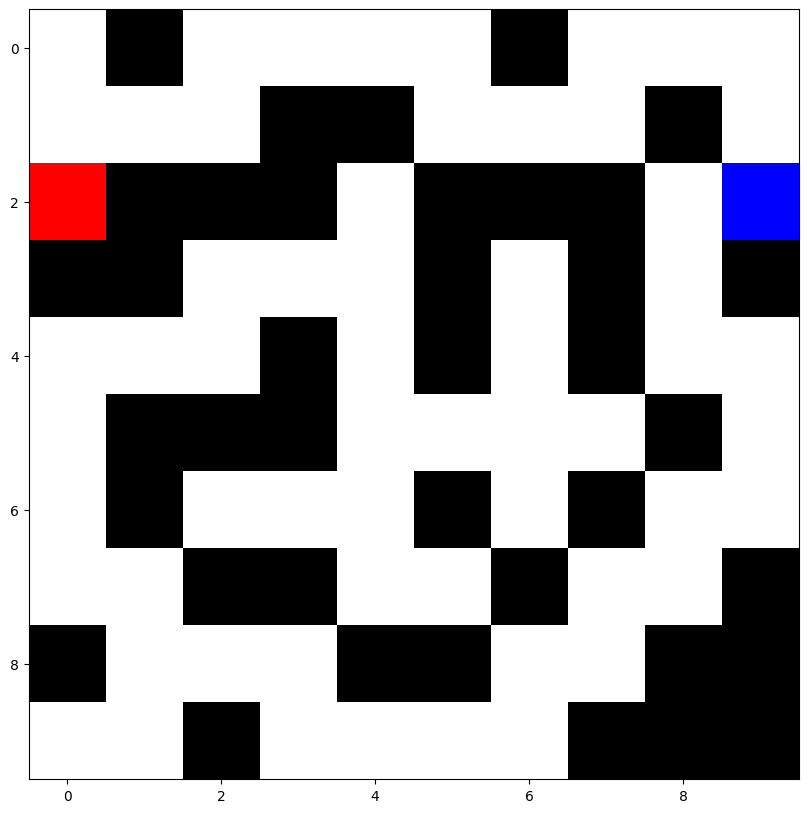

In [24]:
# Podemos construir labirintos com diversas dimensoes (a ciratividade eh sua!)
labirinto = Labirinto(10) # Voces podem alterar a dimensao do labirinto (testei ate o tamanho 30). Caso aumente muito, vai ficar dificil de visualizar o resultado

fig = plt.figure(figsize=(10,10))
plt.imshow(labirinto.getLabirintoPlot())

## Busca em Largura

In [25]:
snapshots = buscaEmLargura(labirinto)

Objetivo (2, 9) encontrado


IndexError: list index out of range

## Busca em profundidade











##Best first






  ddkkjsa

## A*


# Animando o labirinto
Podemos utilizar os labirintos retornados pelo algoritmo de busca para poder visualizar cada uma das iterações do algoritmo. No momento da busca, estão registrados tanto as fronteiras do algoritmo de busca quanto o resultado final encontrado.

In [5]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10,10))

# initialization function: plot the background of each frame
def init():
  a = labirinto.getLabirintoPlot()
  im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)
  return [im]


def animate_func(i):
  im = plt.imshow(snapshots[i], interpolation='none', aspect='auto', vmin=0, vmax=1)
  #im.set_array(snapshots[i])
  return [im]

anim = animation.FuncAnimation(fig,
                               animate_func,
                               init_func=init,
                               frames=len(snapshots), # Numero de frames para animacao
                               interval=100, # Intervalo entre cada frame (em milisegundos)
                               blit=True)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

NameError: name 'snapshots' is not defined

<Figure size 1000x1000 with 0 Axes>